In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style for clean, professional look (like figures.ipynb)
sns.set(style="whitegrid")

# Set figure size for better display
plt.rcParams['figure.figsize'] = (14, 8)

In [18]:
def parse_datenbank_data(file_path):
    """
    Parse the datenbank.txt format and return personnel and project DataFrames
    """
    # Try different encodings to handle special characters
    encodings = ['latin-1', 'iso-8859-1', 'cp1252', 'utf-8']
    content = None
    
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                content = f.read()
            print(f"Successfully read file with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue
    
    if content is None:
        raise ValueError("Could not read file with any of the attempted encodings")
    
    # Split into personnel and project sections
    sections = content.split('Projektdaten')
    if len(sections) < 2:
        raise ValueError("Could not find 'Projektdaten' section in file")
    
    personnel_section = sections[0].strip()
    project_section = sections[1].strip()
    
    # Parse personnel data
    personnel_lines = personnel_section.split('\n')[2:]  # Skip header lines
    personnel_data = []
    
    for line in personnel_lines:
        if line.strip():
            # Parse line: ID Name Competencies 2025 2026 2027
            parts = line.split()
            if len(parts) >= 7:  # Make sure we have enough parts
                person_id = parts[0]
                name = parts[1] + ' ' + parts[2]  # First and last name
                competencies = parts[3].split(',')
                availability_2025 = float(parts[4].replace(',', '.'))
                availability_2026 = float(parts[5].replace(',', '.'))
                availability_2027 = float(parts[6].replace(',', '.'))
                
                personnel_data.append({
                    'id': person_id,
                    'name': name,
                    'competencies': competencies,
                    'availability_2025': availability_2025,
                    'availability_2026': availability_2026,
                    'availability_2027': availability_2027,
                    'total_availability': availability_2025 + availability_2026 + availability_2027
                })
    
    # Parse project data
    project_lines = project_section.split('\n')[6:]  # Skip header lines including "AP von bis PM"
    project_data = []
    
    def fix_invalid_date(date_str):
        """Fix common invalid dates"""
        day, month, year = date_str.split('.')
        day, month, year = int(day), int(month), int(year)
        
        # Fix invalid dates
        if month == 4 and day == 31:  # April 31st doesn't exist
            day = 30
        elif month == 2 and day > 28:  # February issues
            if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):  # Leap year
                if day > 29:
                    day = 29
            else:
                if day > 28:
                    day = 28
        elif month in [4, 6, 9, 11] and day == 31:  # Months with 30 days
            day = 30
        
        return f"{day:02d}.{month:02d}.{year:02d}"
    
    for line in project_lines:
        if line.strip() and not line.startswith('---'):
            # Parse line: AP von bis PM
            parts = line.split()
            if len(parts) >= 4:
                # Handle the AP format more carefully
                ap_part = parts[0]
                if '(' in ap_part and ')' in ap_part:
                    ap_code = ap_part.split('(')[0]  # Extract just the letter
                    ap_name = ap_part.split('(')[1].rstrip(')')  # Extract name in parentheses
                else:
                    # If no parentheses, use the whole part as code
                    ap_code = ap_part
                    ap_name = ap_part
                
                start_date = parts[1]
                end_date = parts[2]
                person_months = float(parts[3].replace(',', '.'))
                
                # Fix invalid dates
                start_date_fixed = fix_invalid_date(start_date)
                end_date_fixed = fix_invalid_date(end_date)
                
                try:
                    # Convert dates to datetime objects
                    start_dt = datetime.strptime(start_date_fixed, '%d.%m.%y')
                    end_dt = datetime.strptime(end_date_fixed, '%d.%m.%y')
                    
                    # Calculate duration in months
                    duration_months = (end_dt.year - start_dt.year) * 12 + (end_dt.month - start_dt.month) + 1
                    
                    project_data.append({
                        'ap_code': ap_code,
                        'ap_name': ap_name,
                        'full_name': f"{ap_code}({ap_name})",
                        'start_date': start_date_fixed,
                        'end_date': end_date_fixed,
                        'start_dt': start_dt,
                        'end_dt': end_dt,
                        'person_months': person_months,
                        'duration_months': duration_months,
                        'monthly_effort': person_months / duration_months
                    })
                    
                except ValueError as e:
                    print(f"Error parsing dates for {ap_code}: {start_date_fixed}, {end_date_fixed}")
                    print(f"Error: {e}")
                    continue
    
    personnel_df = pd.DataFrame(personnel_data)
    project_df = pd.DataFrame(project_data)
    
    return personnel_df, project_df

In [19]:
# Load the results from the genetic algorithm
try:
    results_df = pd.read_csv('../tests/matching_ergebnis_new_format.csv')
    print("Loaded results from CSV file")
    print(f"Total assignments: {len(results_df)}")
except FileNotFoundError:
    print("Results file not found. Please run the genetic algorithm first.")
    results_df = None

# Load original data for comparison
try:
    personnel_df, project_df = parse_datenbank_data("../data/datenbank.txt")
    print(f"Loaded {len(personnel_df)} personnel records")
    print(f"Loaded {len(project_df)} project tasks")
except Exception as e:
    print(f"Error loading original data: {e}")
    personnel_df, project_df = None, None

# Add competency_match column if results exist
if results_df is not None:
    results_df['competency_match'] = results_df.apply(
        lambda row: row['assigned_competency'] in row['competencies'].split(',') 
        if row['person_id'] != 'Unassigned' else False, axis=1
    )

Loaded results from CSV file
Total assignments: 14
Successfully read file with latin-1 encoding
Loaded 7 personnel records
Loaded 14 project tasks


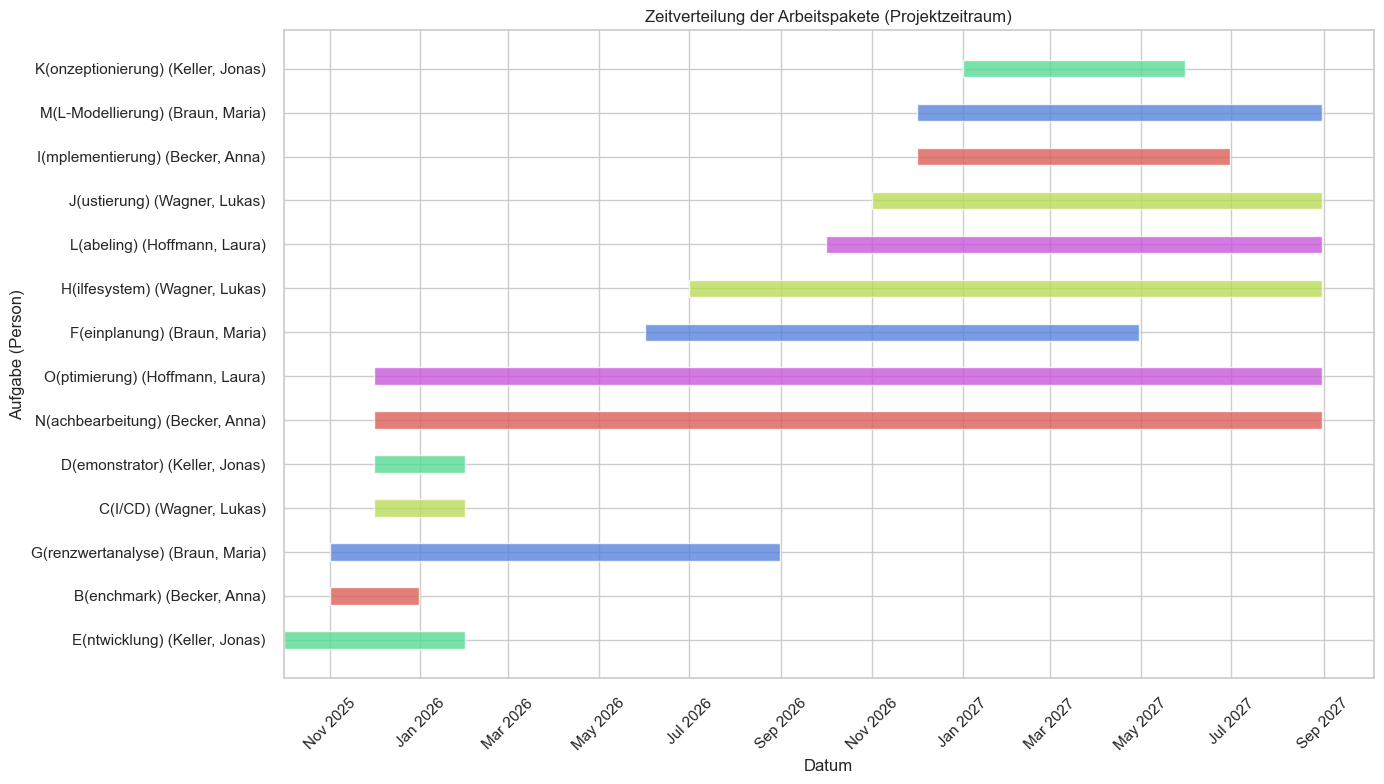

In [20]:
if results_df is not None:
    # Convert dates to datetime for plotting
    results_df['start_dt'] = pd.to_datetime(results_df['start_date'], format='%d.%m.%y')
    results_df['end_dt'] = pd.to_datetime(results_df['end_date'], format='%d.%m.%y')
    
    # Create color palette for different people (like figures.ipynb)
    personen = results_df['person_id'].unique()
    farben = sns.color_palette("hls", len(personen))
    person_colors = dict(zip(personen, farben))
    
    # Plot (following the style from figures.ipynb)
    plt.figure(figsize=(14, 8))
    
    # Sort by start date for better visualization
    results_sorted = results_df.sort_values('start_dt')
    
    # Gantt-Diagramm with horizontal bars
    personen_legende = set()  # legend for people
    for i, row in results_sorted.iterrows():
        if row['person_id'] != 'Unassigned':
            label = row['name'] if row['name'] not in personen_legende else ""
            personen_legende.add(row['name'])
            
            color = person_colors[row['person_id']]
            
            plt.barh(
                y=f"{row['task_name']} ({row['name']})",
                width=(row['end_dt'] - row['start_dt']).days,
                left=row['start_dt'],
                height=0.4,
                color=color,
                label=label,
                alpha=0.8
            )
    
    # Axes and layout (like figures.ipynb)
    plt.xlabel("Datum")
    plt.ylabel("Aufgabe (Person)")
    plt.title("Zeitverteilung der Arbeitspakete (Projektzeitraum)")
    
    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

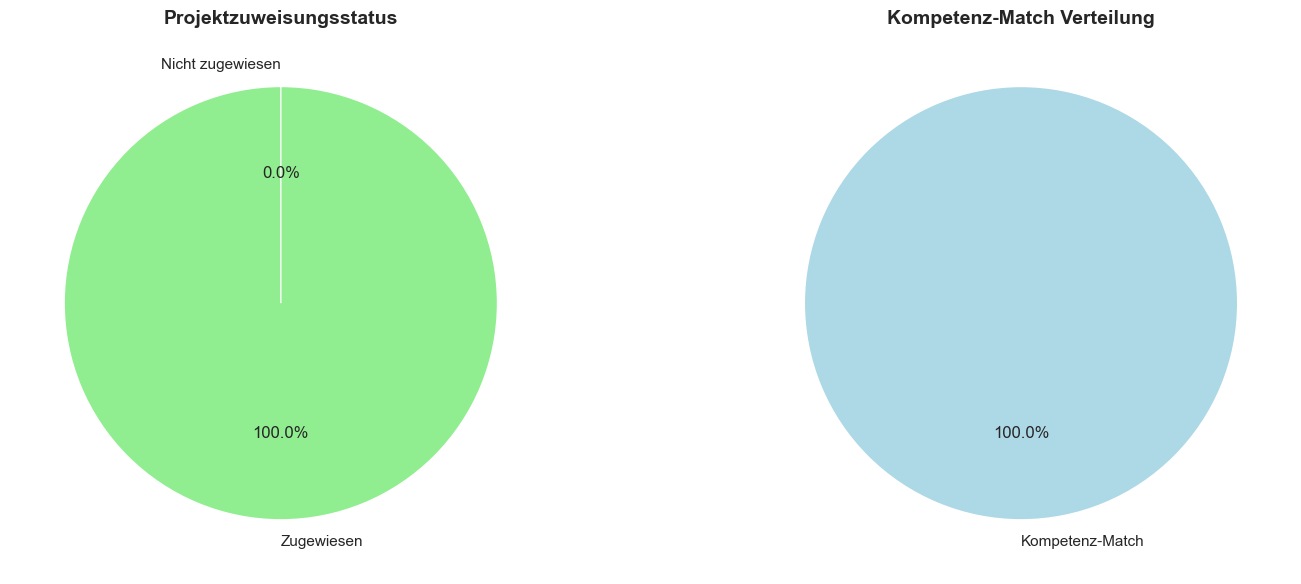

In [21]:
if results_df is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Assignment Status
    assigned_count = len(results_df[results_df['person_id'] != 'Unassigned'])
    unassigned_count = len(results_df[results_df['person_id'] == 'Unassigned'])
    
    ax1.pie([assigned_count, unassigned_count], 
            labels=['Zugewiesen', 'Nicht zugewiesen'], 
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'],
            startangle=90)
    ax1.set_title('Projektzuweisungsstatus', fontsize=14, fontweight='bold')
    
    # 2. Competency Match Distribution - FIXED
    competency_matches = results_df['competency_match'].value_counts()
    
    # Create proper labels based on the actual data
    if len(competency_matches) == 2:
        # Both True and False exist
        labels = ['Kompetenz-Match', 'Kein Match']
        colors_pie = ['lightblue', 'lightyellow']
    elif len(competency_matches) == 1:
        # Only one value exists
        if competency_matches.index[0] == True:
            labels = ['Kompetenz-Match']
            colors_pie = ['lightblue']
        else:
            labels = ['Kein Match']
            colors_pie = ['lightyellow']
    else:
        # No data
        labels = ['Keine Daten']
        colors_pie = ['lightgray']
    
    ax2.pie(competency_matches.values, 
            labels=labels,
            autopct='%1.1f%%',
            colors=colors_pie,
            startangle=90)
    ax2.set_title('Kompetenz-Match Verteilung', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

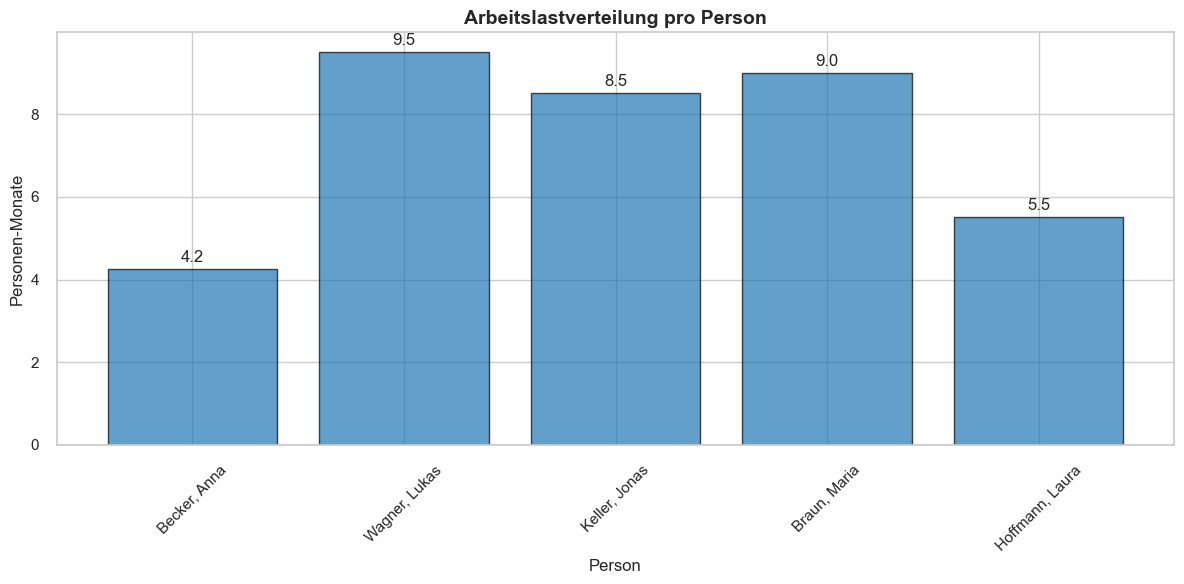

In [22]:
if results_df is not None and personnel_df is not None:
    # Calculate workload per person
    workload_per_person = results_df[results_df['person_id'] != 'Unassigned'].groupby('person_id').agg({
        'person_months': 'sum',
        'monthly_effort': 'sum'
    }).reset_index()
    
    # Convert person_id to string to ensure consistent data types
    workload_per_person['person_id'] = workload_per_person['person_id'].astype(str)
    personnel_df['id'] = personnel_df['id'].astype(str)
    
    # Merge with personnel data to get names
    workload_per_person = workload_per_person.merge(
        personnel_df[['id', 'name']], 
        left_on='person_id', 
        right_on='id', 
        how='left'
    )
    
    plt.figure(figsize=(12, 6))
    
    # Total Person-Months per Person
    bars = plt.bar(workload_per_person['name'], workload_per_person['person_months'], 
                   color='tab:blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Person')
    plt.ylabel('Personen-Monate')
    plt.title('Arbeitslastverteilung pro Person', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [23]:
if results_df is not None:
    # Create a formatted results table
    print("Detaillierte Zuweisungsergebnisse:")
    print("="*80)
    
    # Sort by start date
    results_sorted = results_df.sort_values('start_date')
    
    for idx, row in results_sorted.iterrows():
        status = "✓" if row['competency_match'] else "✗"
        assignment_status = "Zugewiesen" if row['person_id'] != 'Unassigned' else "Nicht zugewiesen"
        
        print(f"{idx+1:2d}. {row['task_name']:<20} → {row['name']:<20} "
              f"{status} ({assignment_status})")
        print(f"     Dauer: {row['start_date']} - {row['end_date']} "
              f"({row['duration_months']} Monate, {row['person_months']:.1f} PM)")
    
    print(f"\nZusammenfassung:")
    print(f"Gesamtprojekte: {len(results_df)}")
    print(f"Zugewiesene Projekte: {len(results_df[results_df['person_id'] != 'Unassigned'])}")
    print(f"Nicht zugewiesene Projekte: {len(results_df[results_df['person_id'] == 'Unassigned'])}")
    print(f"Kompetenz-Matches: {results_df['competency_match'].sum()}")
    print(f"Gesamt Personen-Monate: {results_df['person_months'].sum():.1f}")
    
    if len(results_df[results_df['person_id'] != 'Unassigned']) > 0:
        match_rate = results_df['competency_match'].sum() / len(results_df[results_df['person_id'] != 'Unassigned']) * 100
        print(f"Kompetenz-Match Rate: {match_rate:.1f}%")

Detaillierte Zuweisungsergebnisse:
10. K(onzeptionierung)   → Keller, Jonas        ✓ (Zugewiesen)
     Dauer: 01.01.27 - 31.05.27 (5 Monate, 3.0 PM)
 5. F(einplanung)        → Braun, Maria         ✓ (Zugewiesen)
     Dauer: 01.06.26 - 30.04.27 (11 Monate, 1.0 PM)
 7. H(ilfesystem)        → Wagner, Lukas        ✓ (Zugewiesen)
     Dauer: 01.07.26 - 31.08.27 (14 Monate, 5.0 PM)
 4. E(ntwicklung)        → Keller, Jonas        ✓ (Zugewiesen)
     Dauer: 01.10.25 - 31.01.26 (4 Monate, 3.5 PM)
11. L(abeling)           → Hoffmann, Laura      ✓ (Zugewiesen)
     Dauer: 01.10.26 - 31.08.27 (11 Monate, 4.5 PM)
 1. B(enchmark)          → Becker, Anna         ✓ (Zugewiesen)
     Dauer: 01.11.25 - 31.12.25 (2 Monate, 0.5 PM)
 6. G(renzwertanalyse)   → Braun, Maria         ✓ (Zugewiesen)
     Dauer: 01.11.25 - 31.08.26 (10 Monate, 5.0 PM)
 9. J(ustierung)         → Wagner, Lukas        ✓ (Zugewiesen)
     Dauer: 01.11.26 - 31.08.27 (10 Monate, 4.0 PM)
 2. C(I/CD)              → Wagner, Lukas        